In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchtext
from torch.nn import Parameter

In [0]:
from argparse import Namespace
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [0]:
from google.colab import files, drive
drive.mount('/content/gdrive')

In [0]:
args = Namespace(datapath='/content/gdrive/My Drive/datasets/mnist',
                 batch_sz = 64,
                 lr = 0.001,
                 n_epochs = 50)

In [0]:
training_data = datasets.MNIST(root=args.datapath, download=True, train=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root=args.datapath, download=True, train=False, transform=transforms.ToTensor())

In [0]:
train_dataloader = DataLoader(dataset=training_data, batch_size=args.batch_sz, shuffle=False, num_workers=2)
test_dataloader = DataLoader(dataset=test_data, batch_size=args.batch_sz, shuffle=False, num_workers=2)

In [7]:
num_training_imgs, img_width, img_height = training_data.train_data.shape

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Plot random images to visually check the data

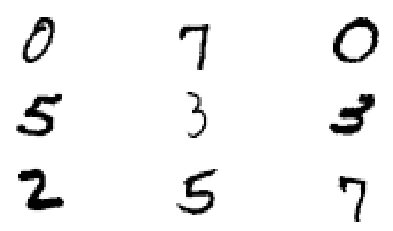

In [8]:
rand_idxs = np.random.randint(0, high=num_training_imgs, size=9 ,dtype='int64')

fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(8, 4))

for idx in range(len(rand_idxs)):
    row, col = idx //3, idx % 3
    
    ax[row, col].imshow(training_data.data[rand_idxs[idx]].numpy())
    ax[row, col].set(xticks=[], yticks=[])
    
plt.show()

In [0]:
use_gpu = torch.cuda.is_available()

In [0]:
train_loss_history = []
per_epoch_loss = []
test_loss_history = []

In [0]:
train_acc_history = []
test_acc_history = []

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 384),
                                     nn.ReLU(),
                                     #nn.Sigmoid(),
                                     nn.Linear(384, 128),
                                     nn.ReLU(),
                                     #nn.Sigmoid(),
                                     nn.Linear(128, 10),
                                     nn.ReLU())
                                     #nn.Tanh())
        self.decoder = nn.Sequential(nn.Linear(10, 128),
                                     nn.ReLU(),
                                     #nn.Sigmoid(),
                                     nn.Linear(128, 384),
                                     nn.ReLU(),
                                     #nn.Sigmoid(),
                                     nn.Linear(384, 28*28),
                                     nn.ReLU())
                                     #nn.Tanh())
        
    def forward(self, X):
        X = X.view(-1, 28*28)
        X = self.encoder(X)
        X = self.decoder(X)
        X = X.view(-1, 1, 28, 28)
        
        return X

In [0]:
simpleAutoEncoder = AutoEncoder()
if use_gpu:
    simpleAutoEncoder = simpleAutoEncoder.cuda()

In [0]:
optimizer = torch.optim.Adam(simpleAutoEncoder.parameters(), lr=args.lr)

In [0]:
lossfn = nn.MSELoss()
#lossfn = nn.NLLLoss()

for i in range(args.n_epochs):
    for batch, (img_data, img_target) in enumerate(train_dataloader):
        img_data = Variable(img_data)
        if use_gpu:
            img_data = img_data.cuda()
        
        #step-1:
        optimizer.zero_grad()
        
        #step-2:
        img_pred = simpleAutoEncoder(img_data)

        
        #step-3:
        #loss = nn.MSELoss(img_pred, img_data)
        loss = lossfn(img_pred, img_data)
        
        #step-4:
        loss.backward()
        optimizer.step()
        
        #extra:
        per_epoch_loss.append(loss.cpu().data)
        if(i%5 == 0):
            #Save Images every 5th epoch to check visually
            img_gen = img_pred.cpu().data
            #print(img_gen.size())
            img_gen = img_gen.view(img_gen.size(0), 1, 28, 28)
            save_image(img_gen, filename='/content/gdrive/My Drive/datasets/mnist/img_{}.png'.format(i)) #, scale_each=True, normalize=True)
            save_image(img_data.cpu(), filename='/content/gdrive/My Drive/datasets/mnist/orig_img_{}.png'.format(i)) #, scale_each=True, normalize=True)
        
        
    train_loss_history.append(np.mean(per_epoch_loss))